## View The Full Interactive Version [Here](https://nbviewer.org/github/HypnoticRegression/Data_Science_Portfolio/blob/main/Paragliding_First_Thermal.ipynb)

In [215]:
import pandas as pd
import glob
import re
import pathlib
import folium 
from folium import Map
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [262]:
#We can parse through the lines of the file and extract the useful data that we want into a DataFrame
#I've added notes below for some other summary functions to understand what we are trying to do.
#I will be improving this parsing function in the future

def igc_file_reader(f):
    df = pd.DataFrame()
    with open(f,'r') as flight:
        site = 'Null'
        date = 'Null'
        pilot = 'Null'
        glider = 'Null'
        tzoffset = 0
        line_count = 0
        df['thermal'] = 0
        while line_count <= 240:
            for line in flight:
                line_count += 1
                if line_count > 250:
                    break
                if (line.startswith('B')): 
                    df = df.append({
                        'timestamp' : int(line[1:7]),
                        'latitude'  : str(line[7:15]),
                        'longitude' : str(line[15:24]),
                        'alt_pressure'  : str(line[25:30]),
                        'alt_gps'   : str(line[30:35]),
                        }, ignore_index=True) 
                elif 'DATE' in line:
                    date = str(re.search(r'\d{6}', line).group(0))
                elif 'HFDTE' in line:
                    date = str(line[5:11])   
                elif 'PILOT' in line:
                    pilot = str(re.search(r'(?<=:)[^\]]+', line).group(0))
                elif 'TZN' in line:
                    tzoffset = str(re.search(r'(?<=:)[^\]]+', line).group(0))  
                elif 'Site' in line:
                    site = str(line.split(":")[1:][0])
                elif 'SITE' in line:
                    site = str(line.split(":")[1:][0])
                elif 'GLIDER' in line:
                    glider = str(line.split(":")[1:][0])
        df['start_location'] = site
        df['date'] = date 
        df['pilot'] = pilot 
        df['flight_id'] = pathlib.PurePath(f).stem
        df['tzoffset'] = tzoffset #record timezone offset, if any are located in the .igc file. Most default to UTC time, some local, and some with offset. More to come on this one.
        df['glider'] = glider
        #Grab The date. We need to add the year into this then convert to datetime
        if df['date'].unique() != 'Null':
            date_fill = df['date'].unique()
            date_fill = date_fill[0]
            df['date'] = date_fill[:-2] + '20' + date_fill[-2:] 
            df['date'] = pd.to_datetime(df['date'],format = '%d%m%Y',dayfirst=True,errors='coerce')

        #Convert the timestamps to datetime and grab the interval. Some logs are in 30 second intervals which won't be useful for analysis
        df['interval'] = (pd.to_datetime(df['timestamp'],format = '%H%M%S',errors='coerce').shift(-1) - pd.to_datetime(df['timestamp'],format = '%H%M%S',errors='coerce'))
        df['interval'] = df['interval'].apply(lambda x: x.total_seconds())
        df['timestamp'] = pd.to_datetime(df['timestamp'],format = '%H%M%S',errors='coerce').dt.strftime('%H:%M:%S')

        #Add all of the other details that we'll need for analysis
        #We are going to use minimum altitude within the first 100 seconds of flight to find thermal source
        df['alt_pressure'] = df['alt_pressure'].astype(int) #Convert altitude back to integer from string
        df['alt_gps'] = df['alt_gps'].astype(int)
        if df['alt_pressure'].mean() <= 1.0:
            alt_measure = 'alt_gps'
        else:
            alt_measure = 'alt_pressure'
        trough = df[alt_measure][:200].min()
        trough_idx = df[alt_measure].to_list().index(trough)
        df['thermal'][trough_idx] = 1
        df['thermal_start'] = df['thermal'] #Identifies the moment of lift and moment of sink
        df['vario'] = df[alt_measure] #Variometer readout, which will be lift per interval
        df = df.replace('\n','', regex=True) #Get rid of any spacing issues caused in parsing to indicate new line breaks
        #Finding and notating first thermal and start and finish
        if df['thermal_start'].to_list().index(1.0) > 0:
            ft_idx = df['thermal_start'].to_list().index(1.0) #Finds first occurance of a thermal to mark the first thermal found in the flight. Needs to be refined. More on that below.
        df['first_thermal'] = 0
        df['first_thermal'][ft_idx] = 1
        df['dd_latitude'] = ''  #Placeholder for later parsing
        df['dd_longitude'] = '' #Placeholder for later parsing
        return df

In [263]:
##Loop through each file in our folder and start formatting and configuring all of the things we will want later
flight_data = pd.DataFrame()
dir_path=r"S:\Data\Paragliding_Data\all_flights\*.igc"
igcfile = glob.glob(dir_path, recursive=True)
file_count = 0
processed_files = 0
for f in igcfile:
    file_count += 1
    try:
        flight_data = flight_data.append(igc_file_reader(f))
        processed_files += 1
    except:
        continue

print(f'Processed {processed_files} out of {file_count} files')


Processed 196 files


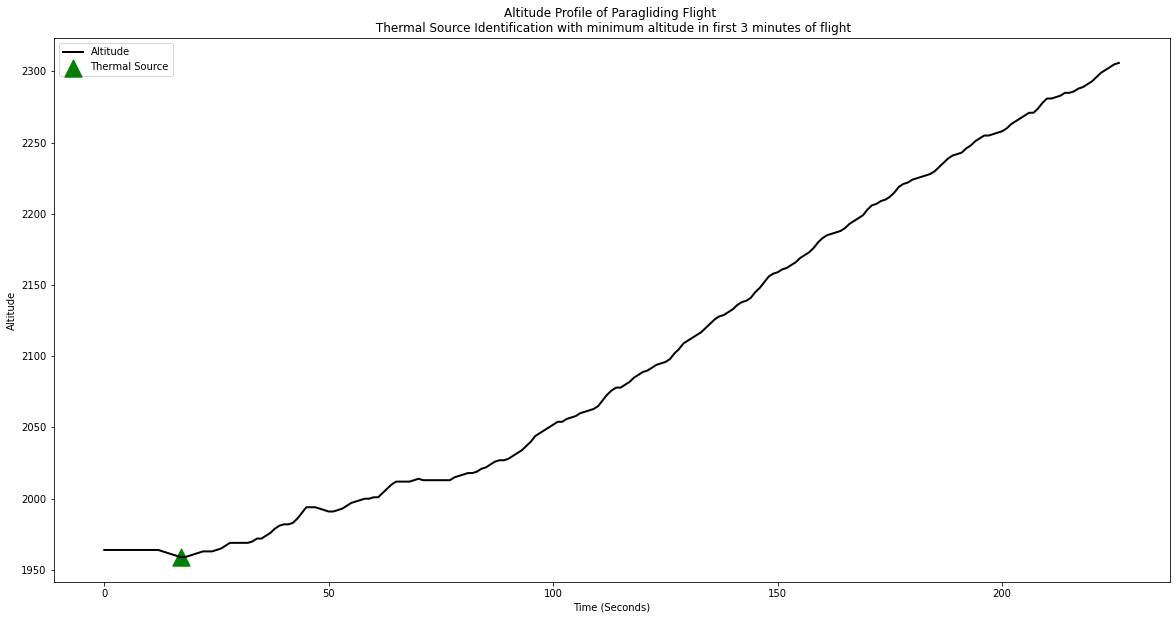

In [264]:
#Plotting Data to check troughs as thermal source location.

#Running our modified igc_file_reader function on a test flight.
test_file_dir = 'S:/Data/Paragliding_Data/all_flights/2022-05-09-XCT-DMI-23.igc'
test_flight = igc_file_reader(test_file_dir)

signal = test_flight['alt_pressure'][:6000].loc[test_flight['thermal_start'] == 1]
fig=plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(ylabel='Altitude',xlabel='Time (Seconds)',title='Altitude Profile of Paragliding Flight \n Thermal Source Identification with minimum altitude in first 3 minutes of flight')
test_flight['alt_pressure'][:6000].plot(ax=ax1,color='black',lw=2, label= 'Altitude')
ax1.scatter(signal.index,signal,marker='^',s = 300,c='g',alpha=1.0,label='Thermal Source')
plt.legend(loc = 'upper left')
plt.show()


In [265]:
#Degrees Minutes Seconds Conversion. This is necessary for formatting if exporting, but we 
#Need to do this to establish the proper breaks in the string for converison to decimal degrees in the next step as OpenStreetMaps and Folium run off of Decimal Degrees
flight_data['latitude'] = flight_data['latitude'].str[:2]+'\u00b0'+ flight_data['latitude'].str[2:4] +'.'+ flight_data['latitude'].str[4:6] + flight_data['latitude'].str[6:7] +'\'' + flight_data['latitude'].str[7:8]
flight_data['longitude'] = flight_data['longitude'].str[:3]+'\u00b0'+ flight_data['longitude'].str[3:5] +'.' + flight_data['longitude'].str[5:7] + flight_data['longitude'].str[7:8]+ '\'' + flight_data['longitude'].str[8:9]

flight_data

,thermal,alt_gps,alt_pressure,latitude,longitude,timestamp,start_location,date,pilot,flight_id,tzoffset,glider,interval,thermal_start,vario,first_thermal,dd_latitude,dd_longitude
0,NaN,1903,1806,40°02.895'N,105°18.003'W,19:09:41,Null,2022-08-04,Amy Le,03-0303,-6.0,,1.0,NaN,1806,0,,
1,NaN,1903,1806,40°02.895'N,105°18.003'W,19:09:42,Null,2022-08-04,Amy Le,03-0303,-6.0,,1.0,NaN,1806,0,,
2,NaN,1903,1806,40°02.895'N,105°18.003'W,19:09:43,Null,2022-08-04,Amy Le,03-0303,-6.0,,1.0,NaN,1806,0,,
3,NaN,1903,1806,40°02.895'N,105°18.003'W,19:09:44,Null,2022-08-04,Amy Le,03-0303,-6.0,,1.0,NaN,1806,0,,
4,NaN,1903,1806,40°02.895'N,105°18.003'W,19:09:45,Null,2022-08-04,Amy Le,03-0303,-6.0,,1.0,NaN,1806,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,NaN,1857,1806,40°03.183'N,105°17.754'W,18:25:47,Boulder-US,2022-04-30,Alejandro Marmol-Velez,IGCeVCc5C,0,,1.0,NaN,1806,0,,
231,NaN,1856,1805,40°03.181'N,105°17.755'W,18:25:48,Boulder-US,2022-04-30,Alejandro Marmol-Velez,IGCeVCc5C,0,,1.0,NaN,1805,0,,
232,NaN,1854,1804,40°03.179'N,105°17.756'W,18:25:49,Boulder-US,2022-04-30,Alejandro Marmol-Velez,IGCeVCc5C,0,,1.0,NaN,1804,0,,
233,NaN,1853,1802,40°03.176'N,105°17.757'W,18:25:50,Boulder-US,2022-04-30,Alejandro Marmol-Velez,IGCeVCc5C,0,,1.0,NaN,1802,0,,


In [266]:
#Now we need to chop out only the first thermal locations. We won't need any other flight data for this analysis. 

flight_data = flight_data.loc[(flight_data['first_thermal'] == 1) & (flight_data['flight_id'] != '2022-08-10-XNA-160478-02')] #Had to chop out one file that was throwing an erroneous lat & long. I'll be refining the flight parser function for better performance later

flight_data = flight_data.reset_index()
flight_data = flight_data.drop('index', axis=1)

In [267]:
#DMS2DD Degrees Minutes Seconds to Decimal Degrees Conversion

#Latitude
for index, row in flight_data.iterrows():
        deg, minutes, direction =  re.split('[°\'"]', str(flight_data['latitude'][index]))
        var1 = (float(deg) + float(minutes)/60)
        var2 = -1 if direction in ['W', 'S'] else 1
        flight_data['dd_latitude'][index] = var1 * var2


#Longitude
for index, row in flight_data.iterrows():
        deg, minutes, direction =  re.split('[°\'"]',str(flight_data['longitude'][index]))
        var1 = (float(deg) + float(minutes)/60)
        var2 = -1 if direction in ['W', 'S'] else 1
        flight_data['dd_longitude'][index] = var1 * var2


In [268]:
flight_data

,thermal,alt_gps,alt_pressure,latitude,longitude,timestamp,start_location,date,pilot,flight_id,tzoffset,glider,interval,thermal_start,vario,first_thermal,dd_latitude,dd_longitude
0,1.0,1895,1788,40°02.954'N,105°17.964'W,19:10:25,Null,2022-08-04,Amy Le,03-0303,-6.0,,1.0,1.0,1788,1,40.049233,-105.2994
1,1.0,1898,1902,40°02.859'N,105°17.989'W,18:44:42,Wonderland,2022-02-01,Vinay Shah,2022-02-01-XCT-VSH-18,0,AIRDESIGN Vivo,1.0,1.0,1902,1,40.04765,-105.299817
2,1.0,1898,1886,40°03.361'N,105°17.888'W,18:12:32,Wonderland,2022-02-06,Bijan Tuysserkani,2022-02-06-XCT-BTU-18,0,FLOW PARAGLIDERS Cosmos,1.0,1.0,1886,1,40.056017,-105.298133
3,1.0,1907,1907,40°03.369'N,105°17.998'W,18:17:52,Wonderland,2022-02-06,Ryan Friedman,2022-02-06-XCT-RFR-01,0,ADVANCE Iota 2,1.0,1.0,1907,1,40.05615,-105.299967
4,1.0,1906,1817,40°03.370'N,105°17.976'W,20:42:58,Null,2022-03-01,Nick Wilder,2022-03-01-XTR-3929046F92A0-02,0,,1.0,1.0,1817,1,40.056167,-105.2996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,1.0,2098,1983,40°03.485'N,105°18.009'W,20:12:40,Wonderland,2022-08-12,Austin Everett,2022-08-12-XCT-AEV-02,0,,1.0,1.0,1983,1,40.058083,-105.30015
191,1.0,1893,1776,40°03.019'N,105°17.968'W,18:14:14,Wonderland,2022-08-12,Mike Lester,2022-08-12-XCT-MLE-18,0,OZONE Zeolite,1.0,1.0,1776,1,40.050317,-105.299467
192,1.0,1909,1908,40°03.368'N,105°17.955'W,19:10:19,"Boulder,US",2022-08-17,Garrett stowall,2022-08-17-XFH-000-01 (1),-6,Phi Symphonia,1.0,1.0,1908,1,40.056133,-105.29925
193,1.0,1893,1893,40°03.287'N,105°17.924'W,18:20:42,"Boulder,US",2022-08-17,Nick Wilder,2022-08-17-XFH-000-01,-6,Ozone Alpina,1.0,1.0,1893,1,40.054783,-105.298733


In [269]:
#Plotting with Folium. Zoom in to see the flight tracks while the pilot is in the thermal!
#We can see in this flight that the pilot traveled quite a distance; over 50 kilometers.

thermals = flight_data.loc[(flight_data['thermal_start'] == 1)]

lat = thermals['dd_latitude']
lng = thermals['dd_longitude']

for_map = Map(location=[40.052167, -105.299983], zoom_start=16,tiles='Stamen Terrain')
north_launch = folium.Marker(location=[40.056193, -105.299981],popup='North Launch', icon=folium.Icon(color='gray', icon='asterisk')).add_to(for_map)
south_launch = folium.Marker(location=[40.048091, -105.299936],popup='South Launch', icon=folium.Icon(color='gray', icon='asterisk')).add_to(for_map)
hm_wide = HeatMap(
    list(zip(lat,lng)),
    min_opacity=0.2,
    radius=24, 
    blur=10, 
    max_zoom=1,
)
for_map.add_child(hm_wide)